In [2]:
!pip install pandas matplotlib seaborn tld

In [3]:
import re # regex
from urllib.parse import urlparse
import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier, plot_importance

from tld import get_tld, is_tld

In [150]:
raw = pd.read_csv("./malicious_phish.csv")
raw.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [151]:
raw = raw.sample(50000)

# Remove the selected observations from the DataFrame
raw.info

<bound method DataFrame.info of                                                       url    type
71485   bcvoice.com/forums/index.php?showtopic=5679&st=40  benign
206293        njlawnet.com/newjerseylawyers/monmouth.html  benign
107676  airport-parking-cheap.com/montreal_pierre_elli...  benign
176101          en.wikipedia.org/wiki/Talk:Standard_Hindi  benign
418617                              australiannation.com/  benign
...                                                   ...     ...
330172                medlibrary.org/medwiki/Galen_Rowell  benign
458013  amazon.com/BLACKHAWK-1989-10-12-Complete-Story...  benign
33013                                    japanpublic.com/  benign
230209  rootsweb.ancestry.com/~rigenweb/cemetery/cemet...  benign
131731                                     laytonlaw.net/  benign

[50000 rows x 2 columns]>

In [152]:
# raw['type'] = raw['type'].astype('category') 
raw['url_type'] = raw['type'].map({'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}).astype(np.int64)
raw.sample(5)

,url,type,url_type
413110,http://www.radiovillage.eu/index.php/component...,defacement,1
527618,https://x2mqj8a.app.link/gzNQm1fEI5?platform=h...,phishing,3
541606,http://85.217.170.105/x86,malware,2
33069,npr.org/templates/story/story.php?storyId=1120...,benign,0
107401,amazon.com/Bernie-Parent/dp/013074526X,benign,0


In [153]:
https_count = raw['url'].str.startswith('https://').sum()
http_count = raw['url'].str.startswith('http://').sum()
neither_count = (~raw['url'].str.startswith(('https://', 'http://'))).sum()

print(f"Total URLs starting with 'https://': {https_count}")
print(f"Total URLs starting with 'http://': {http_count}")
print(f"Total URLs starting with neither: {neither_count}")

Total URLs starting with 'https://': 1198
Total URLs starting with 'http://': 13324
Total URLs starting with neither: 35478


In [154]:
def abnormal_url(url: str) -> int:
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


def process_tld(url):
    try:
        res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
        domain = res.parsed_url.netloc
    except :
        domain = None
    return domain


def httpSecured(url: str) -> int:
    htp = urlparse(url).scheme
    match = str(htp)
    if match == 'https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

def digit_count(url: str) -> int:
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

# Counts the number of letter characters in a URL
def letter_count(url: str) -> int:
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

# ** Checks to see whether URL contains a shortening service **
def shortening_service(url: str) -> int:
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    

def having_ip_address(url: str) -> int:
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

<>:49: SyntaxWarning: invalid escape sequence '\.'
<>:50: SyntaxWarning: invalid escape sequence '\.'
<>:51: SyntaxWarning: invalid escape sequence '\.'
<>:52: SyntaxWarning: invalid escape sequence '\.'
<>:53: SyntaxWarning: invalid escape sequence '\.'
<>:54: SyntaxWarning: invalid escape sequence '\.'
<>:55: SyntaxWarning: invalid escape sequence '\.'
<>:56: SyntaxWarning: invalid escape sequence '\.'
<>:72: SyntaxWarning: invalid escape sequence '\.'
<>:73: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\.'
<>:50: SyntaxWarning: invalid escape sequence '\.'
<>:51: SyntaxWarning: invalid escape sequence '\.'
<>:52: SyntaxWarning: invalid escape sequence '\.'
<>:53: SyntaxWarning: invalid escape sequence '\.'
<>:54: SyntaxWarning: invalid escape sequence '\.'
<>:55: SyntaxWarning: invalid escape sequence '\.'
<>:56: SyntaxWarning: invalid escape sequence '\.'
<>:72: SyntaxWarning: invalid escape sequence '\.'
<>:73: SyntaxWarning: invalid e

In [155]:
# *** omit the (www.) from the URL which is in fact a sub domain in itself. ***
raw['url'] = raw['url'].replace('www.', '', regex=True)
raw.sample(10)

,url,type,url_type
441808,justjared.buzznet.com/2010/09/14/kelly-osbourn...,benign,0
310497,http://midas-medical.com/products/ultrasound/c...,defacement,1
534440,https://pcswm-my.sharepoint.com/:b:/g/personal...,phishing,3
635199,monkey.org/~pilot/,phishing,3
648034,members.tripod.com/realmofamaraya/,phishing,3
406865,johnlscott.com/officedetail.aspx?io=1125048,benign,0
473954,http://mo-artworks.com/blog?start=8,defacement,1
470428,waynecook.com/1872_Gazatteer.html,benign,0
289773,gazillionmovies.com/Actor/V/Va/ValerieWildman.htm,benign,0
62499,encyclopedia.com/topic/Illinois.aspx,benign,0


In [156]:
raw['url_length'] = raw['url'].apply(len)
raw['domain'] = raw['url'].apply(lambda x: process_tld(x))

raw.sample(10)

,url,type,url_type,url_length,domain
534105,http://pay-pai-securty-verifyi-accunt-cmd.agr....,phishing,3,70,pay-pai-securty-verifyi-accunt-cmd.agr.ng
396162,uk.answers.yahoo.com/question/index?qid=201103...,benign,0,61,uk.answers.yahoo.com
489383,entrance-exam.net/forum/general-discussion/lis...,benign,0,93,entrance-exam.net
277781,http://dentagrad.ru/index.php?option=com_conte...,defacement,1,77,dentagrad.ru
151083,http://masseyfergusonsocialclub.co.uk/index.ph...,defacement,1,116,masseyfergusonsocialclub.co.uk
40027,baseballlibrary.com/baseballlibrary/ballplayer...,benign,0,67,baseballlibrary.com
572793,rcmbt.org/includes/vbv/ba5cc1e61b5e3ac8201ae6a...,benign,0,69,rcmbt.org
131977,butchersbuddy.com/,benign,0,18,butchersbuddy.com
235331,http://visualmethod.net/visual/visual/page.htm...,phishing,3,102,visualmethod.net
541687,http://23.95.89.71/skid.mips,malware,2,28,None


In [157]:
raw['https'] = raw['url'].apply(lambda x: httpSecured(x))
raw.sample(10)

,url,type,url_type,url_length,domain,https
68596,http://billh.net/camelotcraftingdaoc/camelotcr...,defacement,1,78,billh.net,0
634250,en.wikipedia.org/wiki/Language-oriented_progra...,phishing,3,51,en.wikipedia.org,0
470732,http://pubyun.com/wiki/lib/exe/js.php?tseed=f1...,malware,2,76,pubyun.com,0
518213,youmix.co.uk/album/70665,benign,0,24,youmix.co.uk,0
332138,http://videoporn24.ru/skins/01/js/prettyPhoto/...,malware,2,65,videoporn24.ru,0
95065,blu-ray.com/movies/Ride-with-the-Devil-Blu-ray...,benign,0,52,blu-ray.com,0
320933,scribd.com/doc/57257991/Complete-PCB-Design-Us...,benign,0,74,scribd.com,0
464014,facebook.com/rhynobabz,benign,0,22,facebook.com,0
16620,en.wikipedia.org/wiki/Cinema_of_the_Philippines,benign,0,47,en.wikipedia.org,0
301309,enotes.com/topic/Brian_Mitchell_(American_foot...,benign,0,51,enotes.com,0


In [158]:
raw['shortening_service'] = raw['url'].apply(lambda x: shortening_service(x))
raw.head()

,url,type,url_type,url_length,domain,https,shortening_service
71485,bcvoice.com/forums/index.php?showtopic=5679&st=40,benign,0,49,bcvoice.com,0,0
206293,njlawnet.com/newjerseylawyers/monmouth.html,benign,0,43,njlawnet.com,0,1
107676,airport-parking-cheap.com/montreal_pierre_elli...,benign,0,80,airport-parking-cheap.com,0,0
176101,en.wikipedia.org/wiki/Talk:Standard_Hindi,benign,0,41,en.wikipedia.org,0,0
418617,australiannation.com/,benign,0,21,australiannation.com,0,0


In [159]:
raw['has_ip_address'] = raw['url'].apply(lambda x: having_ip_address(x))
raw.has_ip_address.value_counts()

has_ip_address
0    49004
1      996
Name: count, dtype: int64

In [160]:
raw['url'] = raw['url'].replace('https://', '', regex=True)
raw['abnormal_url'] = raw['url'].apply(lambda x: abnormal_url(x))

raw.sample(10)

,url,type,url_type,url_length,domain,https,shortening_service,has_ip_address,abnormal_url
607859,frankappraisalsllc.com/PublicAdjuster.html,phishing,3,42,frankappraisalsllc.com,0,0,0,0
449639,limontech.pl,phishing,3,12,limontech.pl,0,0,0,0
225854,http://anahitalaw.com/tv-a-media,defacement,1,32,anahitalaw.com,0,0,0,1
299586,insead.edu/facultyresearch/faculty/profiles/tv...,benign,0,54,insead.edu,0,0,0,0
79964,http://jjoz.com.au/tour-code-index,defacement,1,34,jjoz.com.au,0,0,0,1
334870,youtube.com/watch?v=4a2XmAM528Q,benign,0,31,youtube.com,0,0,0,0
204218,http://torcache.net/torrent/84328A195CEB02E1EF...,benign,0,167,torcache.net,0,0,0,1
613212,unh.edu/transportation/wildcat/index.htm,phishing,3,40,unh.edu,0,0,0,0
575671,remeslennikrf.ru//wp-includes/Text/index.htm,benign,0,44,remeslennikrf.ru,0,0,0,0
182588,organicconsumers.org/articles/article_20567.cfm,benign,0,47,organicconsumers.org,0,0,0,0


In [161]:
raw['digits']  = raw['url'].apply(lambda x: digit_count(x))
raw['letters'] = raw['url'].apply(lambda x: letter_count(x))
raw.sample(10)

,url,type,url_type,url_length,domain,https,shortening_service,has_ip_address,abnormal_url,digits,letters
175427,absoluteastronomy.com/topics/List_of_Robert_Co...,benign,0,58,absoluteastronomy.com,0,0,0,0,0,51
131294,math.syr.edu/DeptRecollections.htm,benign,0,34,math.syr.edu,0,0,0,0,0,30
503946,linkpendium.com/genealogy/USA/OH/Allen/,benign,0,39,linkpendium.com,0,0,0,0,0,33
587450,scgxedu.com/JS/?us.battle.net/login/en/?ref=cg...,benign,0,91,scgxedu.com,0,0,0,0,2,69
633235,hindu.com/thehindu/biz/2003/05/19/stories/2003...,phishing,3,62,hindu.com,0,0,0,0,24,29
293733,imdb.com/name/nm3315671/,benign,0,24,imdb.com,0,0,0,0,7,13
643270,lencom.com/SurfVCR.html,phishing,3,23,lencom.com,0,0,0,0,0,20
464099,encyclopedia2.thefreedictionary.com/Vincennes,benign,0,45,encyclopedia2.thefreedictionary.com,0,0,0,0,1,41
593125,bmdesign.comze.com/cadastro.html?BTCPB6G697EJ1...,benign,0,197,bmdesign.comze.com,0,0,0,0,43,149
218226,classmates.com/directory/school/College%20of%2...,benign,0,67,classmates.com,0,0,0,0,9,50


In [162]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    raw[a] = raw['url'].apply(lambda i: i.count(a))
raw.head()

,url,type,url_type,url_length,domain,https,shortening_service,has_ip_address,abnormal_url,digits,...,=,.,#,%,+,$,!,*,",",//
71485,bcvoice.com/forums/index.php?showtopic=5679&st=40,benign,0,49,bcvoice.com,0,0,0,0,6,...,2,2,0,0,0,0,0,0,0,0
206293,njlawnet.com/newjerseylawyers/monmouth.html,benign,0,43,njlawnet.com,0,1,0,0,0,...,0,2,0,0,0,0,0,0,0,0
107676,airport-parking-cheap.com/montreal_pierre_elli...,benign,0,80,airport-parking-cheap.com,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
176101,en.wikipedia.org/wiki/Talk:Standard_Hindi,benign,0,41,en.wikipedia.org,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
418617,australiannation.com/,benign,0,21,australiannation.com,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [163]:
hello = raw[raw["abnormal_url"] == 0]

https_count = hello['url'].str.startswith('https://').sum()
http_count = hello['url'].str.startswith('http://').sum()
neither_count = (~hello['url'].str.startswith(('https://', 'http://'))).sum()

print(f"Total URLs starting with 'https://': {https_count}")
print(f"Total URLs starting with 'http://': {http_count}")
print(f"Total URLs starting with neither: {neither_count}")

# hello[["url", "abnormal_url"]].sample(20)

Total URLs starting with 'https://': 0
Total URLs starting with 'http://': 1
Total URLs starting with neither: 36675


In [164]:
raw.sample(15)

,url,type,url_type,url_length,domain,https,shortening_service,has_ip_address,abnormal_url,digits,...,=,.,#,%,+,$,!,*,",",//
155637,wn.com/Jack_White_(film_producer),benign,0,33,wn.com,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
18408,baseball-almanac.com/players/player.php?p=stow...,benign,0,51,baseball-almanac.com,0,0,0,0,2,...,1,2,0,0,0,0,0,0,0,0
631518,syntropy.se/index.php?ct=downloads,phishing,3,34,syntropy.se,0,0,0,0,0,...,1,2,0,0,0,0,0,0,0,0
646146,boardgamegeek.com/game/13,phishing,3,25,boardgamegeek.com,0,0,0,0,2,...,0,1,0,0,0,0,0,0,0,0
522018,particulares.newsbusiniesstoday.net/login,phishing,3,49,particulares.newsbusiniesstoday.net,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
336991,http://stackoverflow.com/questions/30058780/ho...,benign,0,124,stackoverflow.com,0,0,0,1,8,...,0,1,0,0,0,0,0,0,0,1
592972,rotr.co/paypal.com/cgi-bin/us/125335c73257e903...,benign,0,109,rotr.co,0,0,0,0,21,...,0,4,0,0,0,0,0,0,0,0
307030,columbian.com/news/2011/oct/03/golf-course-swi...,benign,0,74,columbian.com,0,0,0,0,6,...,0,1,0,0,0,0,0,0,0,0
495356,answers.com/topic/sponde-jean-de,benign,0,32,answers.com,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
25012,iloveindia.com/finance/bank/foreign-banks/inde...,benign,0,52,iloveindia.com,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [165]:
raw.columns

Index(['url', 'type', 'url_type', 'url_length', 'domain', 'https',
       'shortening_service', 'has_ip_address', 'abnormal_url', 'digits',
       'letters', '@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',',
       '//'],
      dtype='object')

In [166]:
input_cols = ['url_length', 'https', 'shortening_service', 'has_ip_address', 'abnormal_url', 'digits',
       'letters', '@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']

target = raw['url_type']
inputs = raw[input_cols]

inputs.head()

,url_length,https,shortening_service,has_ip_address,abnormal_url,digits,letters,@,?,-,=,.,#,%,+,$,!,*,",",//
71485,49,0,0,0,0,6,35,0,1,0,2,2,0,0,0,0,0,0,0,0
206293,43,0,1,0,0,0,39,0,0,0,0,2,0,0,0,0,0,0,0,0
107676,80,0,0,0,0,0,70,0,0,2,0,2,0,0,0,0,0,0,0,0
176101,41,0,0,0,0,0,35,0,0,0,0,2,0,0,0,0,0,0,0,0
418617,21,0,0,0,0,0,19,0,0,0,0,1,0,0,0,0,0,0,0,0


In [167]:
scaler = StandardScaler()

scaled_inputs = scaler.fit_transform(inputs)
scaled_inputs = pd.DataFrame(scaled_inputs, columns=inputs.columns)
scaled_inputs.head()

,url_length,https,shortening_service,has_ip_address,abnormal_url,digits,letters,@,?,-,=,.,#,%,+,$,!,*,",",//
0,-0.238308,-0.156679,-0.254254,-0.142565,-0.602735,0.042898,-0.308605,-0.047064,1.758847,-0.518385,0.914663,-0.010437,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
1,-0.372509,-0.156679,3.933070,-0.142565,-0.602735,-0.493816,-0.182028,-0.047064,-0.508351,-0.518385,-0.400528,-0.010437,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
2,0.455062,-0.156679,-0.254254,-0.142565,-0.602735,-0.493816,0.798942,-0.047064,-0.508351,0.142264,-0.400528,-0.010437,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
3,-0.417242,-0.156679,-0.254254,-0.142565,-0.602735,-0.493816,-0.308605,-0.047064,-0.508351,-0.518385,-0.400528,-0.010437,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
4,-0.864578,-0.156679,-0.254254,-0.142565,-0.602735,-0.493816,-0.814912,-0.047064,-0.508351,-0.518385,-0.400528,-0.722365,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665


In [168]:
train_inputs, test_inputs, train_target, test_target = split(
    scaled_inputs, target, test_size=.20, random_state=42)
print(
    f"Train shape: {train_inputs.shape} | Target shape: {train_target.shape}", 
    f"Test shape: {test_inputs.shape} | Test target shape: {test_target.shape}", 
    sep="\n",
)

Train shape: (40000, 20) | Target shape: (40000,)
Test shape: (10000, 20) | Test target shape: (10000,)


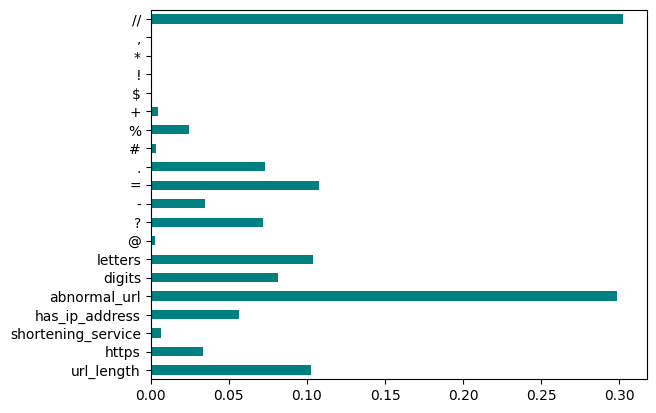

In [169]:
importances = mutual_info_classif(train_inputs, train_target)
feat_importances = pd.Series(importances, train_inputs.columns)
feat_importances.plot(kind='barh', color='teal');

In [170]:
def train(model, X, y, average: str = 'macro') -> None:
    preds = model.predict(X)
    metric_summary(y, preds, average)
    
def metric_summary(y, preds, average) -> None:
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average=average)
    rcl = recall_score(y, preds, average=average)
    print(
        f"Accuracy: {(acc * 100):.2f} %", 
        f"f1: {f1:.2f}", 
        f"recall: {rcl:.2f}", sep="\n"
    )

In [171]:
rf_model = RandomForestClassifier(random_state=42).fit(train_inputs, train_target)
train(model=rf_model, X=test_inputs, y=test_target)

Accuracy: 88.94 %
f1: 0.83
recall: 0.81


In [172]:
test_url = [
    "https://www.nsnam.com/2023/07/installation-of-ns3-in-ubuntu-2204-ns.html", 
    "https://iss-tracker.kaculoss.com",
    "https://www.youtube.com/",
    "mp3raid.com/music/krizz_kaliko.html",
    "https://www.paypal.com",
    "https://1^www.paypa1.com",
    "https://www.bankofamerica.com",
    "https://www.bankofamerica.secure-login.com",
    "https://www.google.com",
    "https://www.go0gle.com",
    "https://www.amazon.com",
    "https://www.microsoft.com",
    "https://www.mircosoft.com",
    "https://www.apple.com",
    "https://www.apple-verification.com",
    "https://www.chase.com",
    "https://chase.com.verify-login.info"
]

test_input = pd.DataFrame(test_url, columns=["url"])

test_input['url'] = test_input['url'].replace('www.', '', regex=True)

test_input['url_length'] = test_input['url'].apply(len)

test_input['domain'] = test_input['url'].apply(lambda x: process_tld(x))

test_input['https'] = test_input['url'].apply(lambda x: httpSecured(x))

test_input['shortening_service'] = test_input['url'].apply(lambda x: shortening_service(x))

test_input['has_ip_address'] = test_input['url'].apply(lambda x: having_ip_address(x))

test_input['url'] = test_input['url'].replace('https://', '', regex=True)

test_input['abnormal_url'] =test_input['url'].apply(lambda x: abnormal_url(x))

test_input['digits']  = test_input['url'].apply(lambda x: digit_count(x))

test_input['letters'] = test_input['url'].apply(lambda x: letter_count(x))

for a in feature:
    test_input[a] = test_input['url'].apply(lambda i: i.count(a))  

    
test_input = test_input[input_cols]

scaled_test_input = scaler.transform(test_input)
scaled_test_input = pd.DataFrame(scaled_test_input, columns=test_input.columns)

scaled_test_input.head()

,url_length,https,shortening_service,has_ip_address,abnormal_url,digits,letters,@,?,-,=,.,#,%,+,$,!,*,",",//
0,0.186661,6.382494,-0.254254,-0.142565,-0.602735,0.490159,-0.213672,-0.047064,-0.508351,1.463561,-0.400528,-0.010437,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
1,-0.618543,6.382494,-0.254254,-0.142565,-0.602735,-0.493816,-0.751623,-0.047064,-0.508351,-0.188060,-0.400528,-0.010437,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
2,-0.886945,6.382494,-0.254254,-0.142565,-0.602735,-0.493816,-1.099709,-0.047064,-0.508351,-0.518385,-0.400528,-0.722365,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
3,-0.551443,-0.156679,-0.254254,-0.142565,-0.602735,-0.404364,-0.498470,-0.047064,-0.508351,-0.518385,-0.400528,-0.010437,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665
4,-0.931678,6.382494,-0.254254,-0.142565,-0.602735,-0.493816,-1.131354,-0.047064,-0.508351,-0.518385,-0.400528,-0.722365,-0.025793,-0.115766,-0.108122,-0.012136,-0.023604,-0.012163,-0.030777,-0.600665


In [173]:
pred = rf_model.predict(test_input)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [174]:
import pickle

In [175]:
data = {"model": rf_model, "scaler": scaler,}
with open("saved_steps.pkl", "wb") as file:
    pickle.dump(data, file)

In [32]:
with open("saved_steps.pkl", "rb") as file:
    data = pickle.load(file)

model_loaded = data["model"]
scaler_loaded = data["scaler"]

In [38]:
test_url = [
    "https://www.nsnam.com/2023/07/installation-of-ns3-in-ubuntu-2204-ns.html", 
    "https://iss-tracker.kaculoss.com",
    "https://www.youtube.com/",
    "mp3raid.com/music/krizz_kaliko.html",
    "https://www.paypal.com",
    "https://1^www.paypa1.com",
    "https://www.bankofamerica.com",
    "https://www.bankofamerica.secure-login.com",
    "https://www.google.com",
    "https://www.go0gle.com",
    "https://www.amazon.com",
    "https://www.microsoft.com",
    "https://www.mircosoft.com",
    "https://www.apple.com",
    "https://www.apple-verification.com",
    "https://www.chase.com",
    "https://chase.com.verify-login.info",
    "abc"
]

test_input = pd.DataFrame(test_url, columns=["url"])

test_input['url'] = test_input['url'].replace('www.', '', regex=True)

test_input['url_length'] = test_input['url'].apply(len)

test_input['domain'] = test_input['url'].apply(lambda x: process_tld(x))

test_input['https'] = test_input['url'].apply(lambda x: httpSecured(x))

test_input['shortening_service'] = test_input['url'].apply(lambda x: shortening_service(x))

test_input['has_ip_address'] = test_input['url'].apply(lambda x: having_ip_address(x))

test_input['url'] = test_input['url'].replace('https://', '', regex=True)

test_input['abnormal_url'] =test_input['url'].apply(lambda x: abnormal_url(x))

test_input['digits']  = test_input['url'].apply(lambda x: digit_count(x))

test_input['letters'] = test_input['url'].apply(lambda x: letter_count(x))

for a in feature:
    test_input[a] = test_input['url'].apply(lambda i: i.count(a))  

    
test_input = test_input[input_cols]

scaled_test_input = scaler_loaded.transform(test_input)
scaled_test_input = pd.DataFrame(scaled_test_input, columns=test_input.columns)

scaled_test_input

,url_length,https,shortening_service,has_ip_address,abnormal_url,digits,letters,@,?,-,=,.,#,%,+,$,!,*,",",//
0,0.193705,6.366321,-0.254988,-0.139829,-0.599886,0.467880,-0.208379,-0.040954,-0.50719,1.496481,-0.398075,-0.003205,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
1,-0.614892,6.366321,-0.254988,-0.139829,-0.599886,-0.472280,-0.750103,-0.040954,-0.50719,-0.184886,-0.398075,-0.003205,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
2,-0.884425,6.366321,-0.254988,-0.139829,-0.599886,-0.472280,-1.100630,-0.040954,-0.50719,-0.521160,-0.398075,-0.718416,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
3,-0.547509,-0.157077,-0.254988,-0.139829,-0.599886,-0.386811,-0.495174,-0.040954,-0.50719,-0.521160,-0.398075,-0.003205,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
4,-0.929347,6.366321,-0.254988,-0.139829,-0.599886,-0.472280,-1.132496,-0.040954,-0.50719,-0.521160,-0.398075,-0.718416,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
5,-0.884425,6.366321,-0.254988,-0.139829,-0.599886,-0.301342,-1.164362,-0.040954,-0.50719,-0.521160,-0.398075,-0.718416,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
6,-0.772120,6.366321,-0.254988,-0.139829,-0.599886,-0.472280,-0.909433,-0.040954,-0.50719,-0.521160,-0.398075,-0.718416,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
7,-0.480126,6.366321,-0.254988,-0.139829,-0.599886,-0.472280,-0.558906,-0.040954,-0.50719,-0.184886,-0.398075,-0.003205,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
8,-0.929347,6.366321,-0.254988,-0.139829,-0.599886,-0.472280,-1.132496,-0.040954,-0.50719,-0.521160,-0.398075,-0.718416,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463
9,-0.929347,6.366321,-0.254988,-0.139829,-0.599886,-0.386811,-1.164362,-0.040954,-0.50719,-0.521160,-0.398075,-0.718416,-0.026935,-0.116419,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.597463


In [39]:
pred = model_loaded.predict(test_input)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)